In [333]:
#basic imports 
import pandas as pd
import numpy as np
import scipy

#model imports
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

#data splitting 
from sklearn.model_selection import train_test_split

#data plotting
import matplotlib.pyplot as plt
import seaborn as sns

#display preferences
sns.set(style="whitegrid")
%matplotlib inline

In [334]:
#open/read data and copy and store in each models own df for ease of feature creation 
df = pd.read_csv('Whiskey_Distillery.csv')
df_osl = df.copy()
df_knn = df.copy()

In [335]:
#after inspecing the data, it came to my attention that the distillery's Spirit/Wash offerings alongside other columns just didn't have enough data to serve as a useful tool for predictions, so I'm dropping those columns
df_osl.drop(['Unnamed: 0', 'Country','Ranking','Company', 'Status', 'Capacity', 'SpiritStill', 'WashStill', 'Owner','Specialist', 'Address','lon','lat','Founded'], axis=1, inplace=True)
#the below code for droping null & zero values in our rating significantly decreases both models performances 
#df_osl.Rating.replace('NaN', np.nan)   
#df_osl = df_osl.dropna(subset=['Rating'])
#df_osl = df_osl[(df.Rating != 0)]
print(df_osl.info())
print(df_osl.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 7 columns):
Closed        59 non-null object
Views         1157 non-null int64
Votes         773 non-null float64
Wishlist      619 non-null float64
Rating        1047 non-null float64
Whisky        1091 non-null float64
Collection    951 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 58.8+ KB
None
  Closed  Views  Votes  Wishlist  Rating  Whisky  Collection
0    NaN   8123   17.0      10.0   32.63     8.0        18.0
1    NaN   2546    NaN       NaN    0.00     2.0         2.0
2    NaN   2671    5.0       NaN   73.67     3.0         3.0
3    NaN    722   47.0      14.0   84.40    10.0        65.0
4    NaN   2315    NaN       NaN     NaN     3.0         1.0


In [336]:
#drop na values first from rating 
df_osl.fillna(0, inplace=True)
for col in df_osl.iloc[:, 0:]:
    df_osl[col] = df_osl[col].replace('[^0-9]+', '', regex=True)
    df_osl[col] = df_osl[col].astype('int64')
print(df_osl.info())
print(df_osl.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 7 columns):
Closed        1157 non-null int64
Views         1157 non-null int64
Votes         1157 non-null int64
Wishlist      1157 non-null int64
Rating        1157 non-null int64
Whisky        1157 non-null int64
Collection    1157 non-null int64
dtypes: int64(7)
memory usage: 63.3 KB
None
   Closed  Views  Votes  Wishlist  Rating  Whisky  Collection
0       0   8123     17        10      32       8          18
1       0   2546      0         0       0       2           2
2       0   2671      5         0      73       3           3
3       0    722     47        14      84      10          65
4       0   2315      0         0       0       3           1


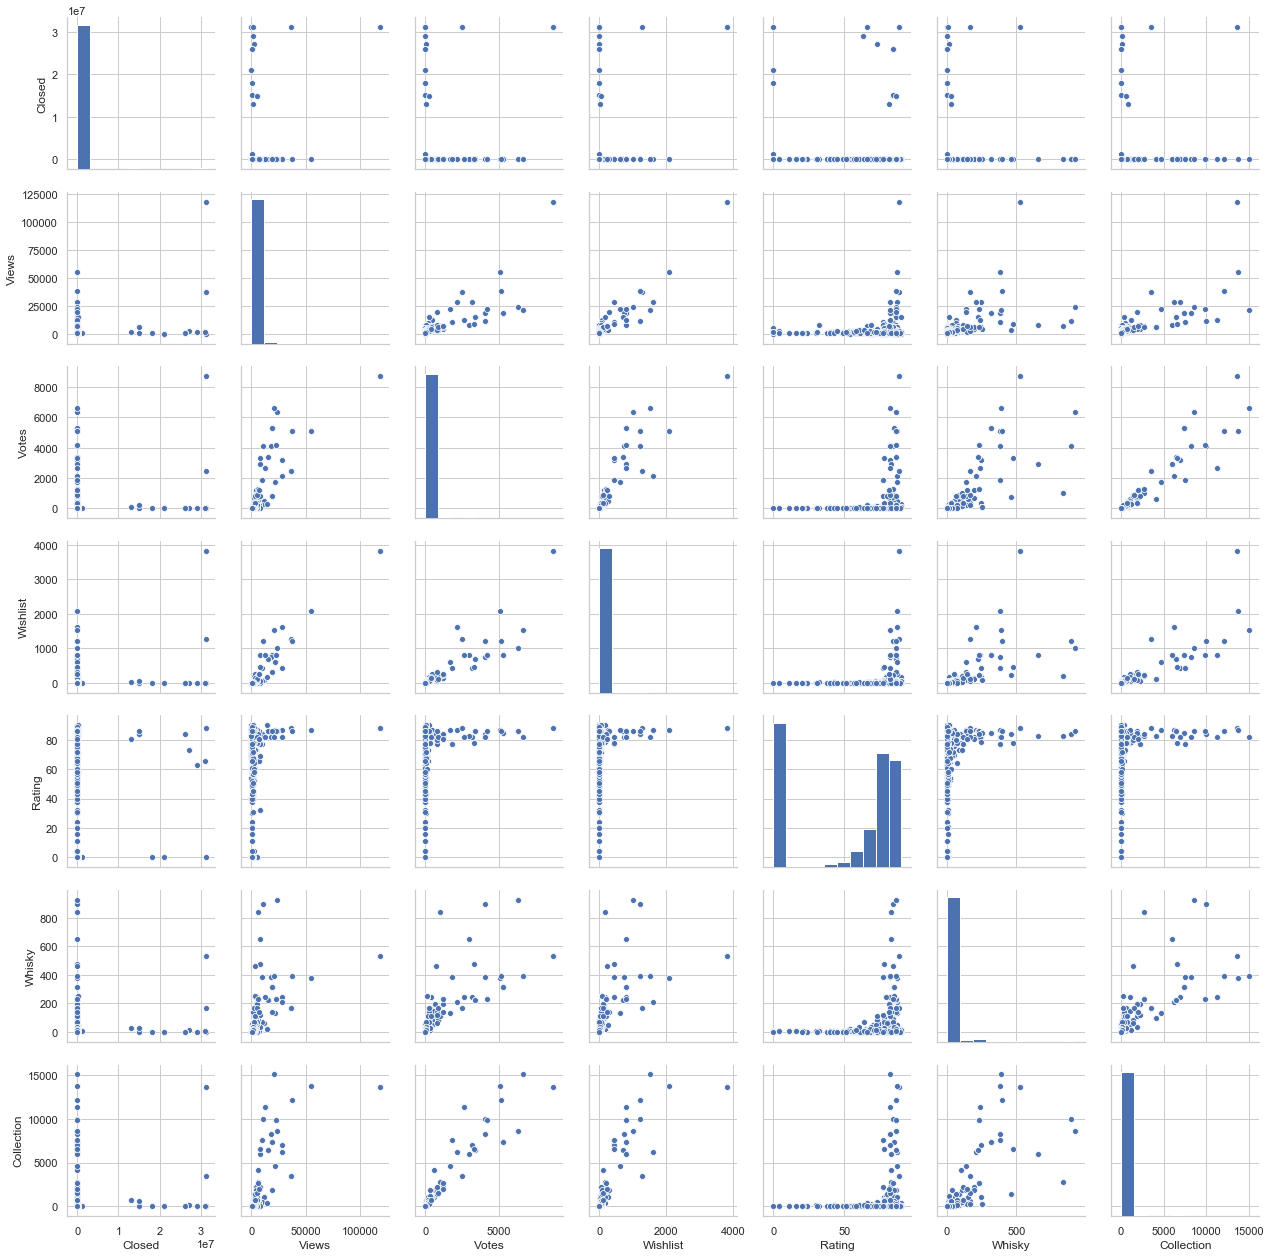

In [337]:
sns.pairplot(df_osl)

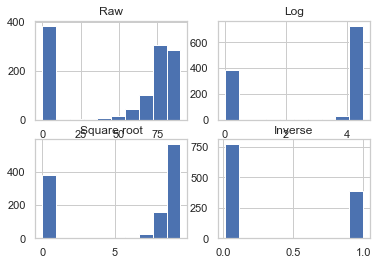

In [338]:
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df_osl['Rating'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df_osl['Rating']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df_osl['Rating'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df_osl['Rating']+1))
plt.title('Inverse')
plt.show()

In [339]:
#categorical variable 
df_osl['Closed'] = np.where((df_osl['Closed'] > 0), 1, 0) 

In [340]:
#normalize data  
df_osl['Views'] = (np.log(df_osl['Views']+1))
df_osl['Votes'] = (np.log(df_osl['Votes']+1))
df_osl['Wishlist'] = (np.log(df_osl['Wishlist']+1))
df_osl['Whisky'] = (np.log(df_osl['Whisky']+1))
df_osl['Collection'] = (np.log(df_osl['Collection']+1))

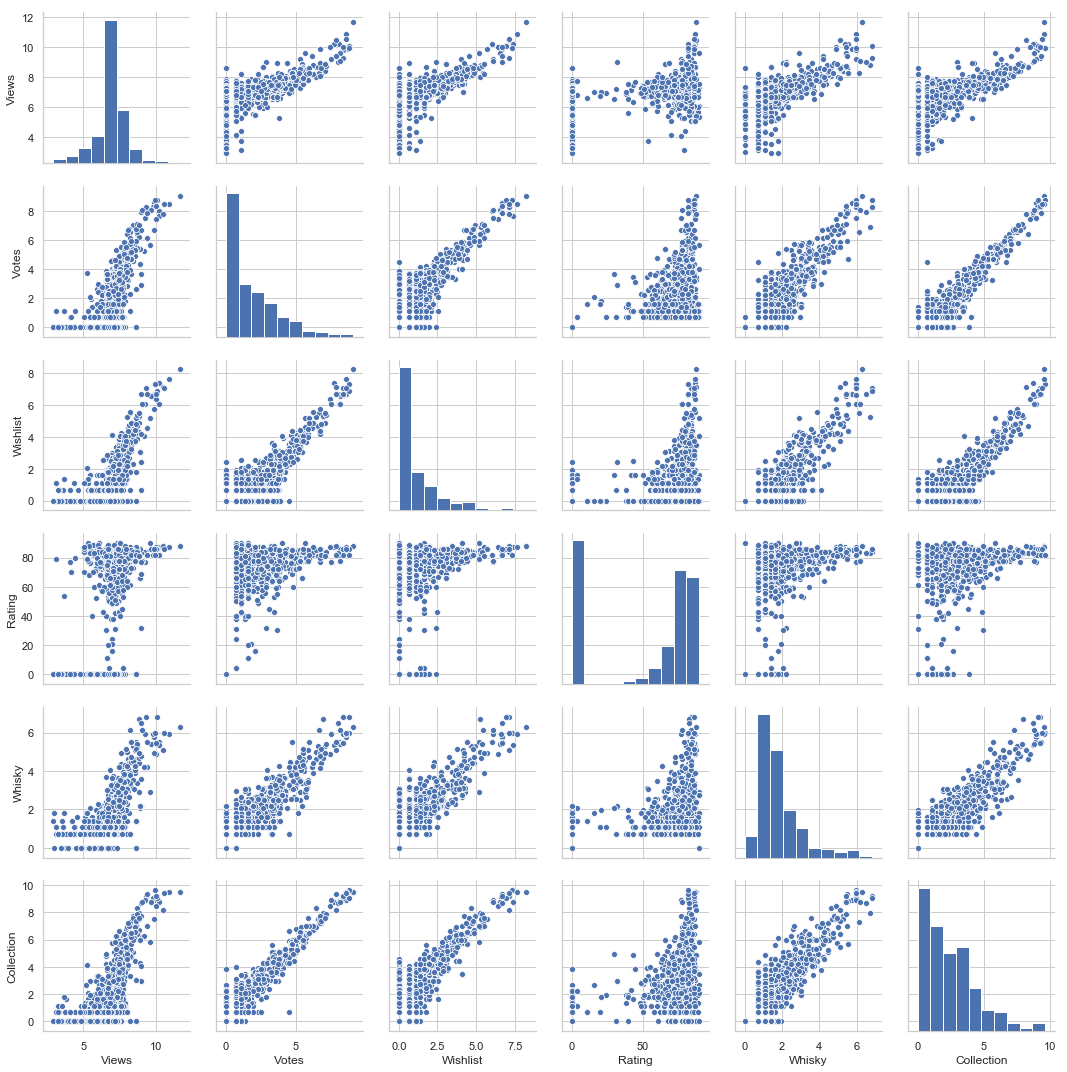

In [341]:
sns.pairplot(df_osl.iloc[:, 1:])

In [342]:
df_osl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 7 columns):
Closed        1157 non-null int32
Views         1157 non-null float64
Votes         1157 non-null float64
Wishlist      1157 non-null float64
Rating        1157 non-null int64
Whisky        1157 non-null float64
Collection    1157 non-null float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 58.8 KB


In [343]:
corrmat = df_osl.corr()
print(corrmat)

              Closed     Views     Votes  Wishlist    Rating    Whisky  \
Closed      1.000000  0.110916  0.087886  0.144029  0.029534  0.130922   
Views       0.110916  1.000000  0.686162  0.644865  0.466232  0.657524   
Votes       0.087886  0.686162  1.000000  0.874184  0.681416  0.860768   
Wishlist    0.144029  0.644865  0.874184  1.000000  0.494975  0.841409   
Rating      0.029534  0.466232  0.681416  0.494975  1.000000  0.530502   
Whisky      0.130922  0.657524  0.860768  0.841409  0.530502  1.000000   
Collection  0.044640  0.676858  0.949479  0.867821  0.632749  0.867350   

            Collection  
Closed        0.044640  
Views         0.676858  
Votes         0.949479  
Wishlist      0.867821  
Rating        0.632749  
Whisky        0.867350  
Collection    1.000000  


In [344]:
#split through scikitlearn then apply to stats model 
#pandas sample from df 
x = np.array([df_osl.Views, df_osl.Votes, df_osl.Wishlist, df_osl.Whisky, df_osl.Collection])
y = df_osl['Rating']
print(x.shape)
print(y.shape)
x = x.transpose()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)

print('\nCoefficients: \n', linear_regression.coef_)
print('\nIntercept: \n', linear_regression.intercept_)
print('\nTraining Data: ' + str(linear_regression.score(X_train, y_train)))
print('Test Data: ' + str(linear_regression.fit(X_test, y_test).score(X_test, y_test)))

(5, 1157)
(1157,)

Coefficients: 
 [ 0.14957882 19.84517324 -9.9214073  -2.47882544  1.40087323]

Intercept: 
 25.983923185493644

Training Data: 0.5163820401625902
Test Data: 0.49461127115685155


In [345]:
print('\nR-squared:\n', linear_regression.score(x, y))


R-squared:
 0.5040985171993815


In [346]:
from sklearn.model_selection import cross_val_score
cross_val_score(linear_regression, x, y, cv=10)

array([0.41233854, 0.09277478, 0.45673725, 0.5757293 , 0.55258812,
       0.48400026, 0.52101751, 0.53141363, 0.49209416, 0.49336407])

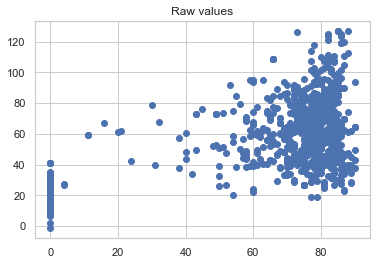

In [347]:
outcome = y
predicted = linear_regression.predict(x).ravel()

plt.scatter(outcome, predicted)
plt.title('Raw values')
plt.show()

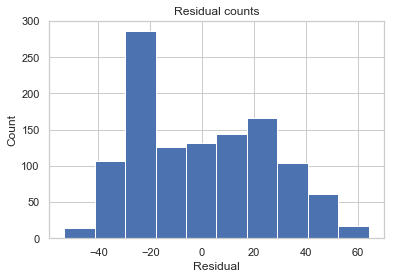

In [348]:
#check assumption 2, multivariate normality 
residual = outcome - predicted

# looks pretty good! 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

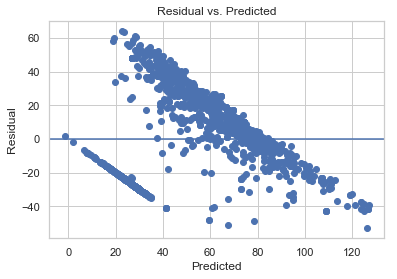

In [349]:
#check assumption three homoscedasticity  
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [350]:
#assumption #4, low multicollinearity
b = np.corrcoef(x)
print (b)

[[1.         0.97793918 0.98098545 ... 0.79754233 0.91746377 0.9825977 ]
 [0.97793918 1.         0.97521501 ... 0.71609715 0.89552628 0.99533222]
 [0.98098545 0.97521501 1.         ... 0.78142983 0.94479601 0.98911356]
 ...
 [0.79754233 0.71609715 0.78142983 ... 1.         0.92036628 0.76649003]
 [0.91746377 0.89552628 0.94479601 ... 0.92036628 1.         0.93294741]
 [0.9825977  0.99533222 0.98911356 ... 0.76649003 0.93294741 1.        ]]


Very obviously our model doesn't have the best linear relationship, has horrible heteroscedasticity, and decently high multicolinearity amongst the variables. I would usually go about fixing these steps, but for now and for the purpose of this challenge, we'll check to compare these varaibles as is to our KNN model. 

In [353]:
KNN = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
KNN.fit(X_train, y_train)

print('Training: ' + str(KNN.score(X_train, y_train)))
print('Test: ' + str(KNN.score(X_test, y_test)))

Training: 0.9443185687859608
Test: 0.9270831937203892


## Conclusion 

KNN outperforms the linear regression model by a long shot. As stated earlier data here very obviously doesn't reflect the four assumptions of a OSL regression well, which makes it difficult to build a successful OSL model. The KNN model doesn't take into assumptions for the model to properly perform that an OSL model would, thus KNN outperformed our OSL. Although, we do have to take into account this is a smaller dataset and the KNN model is best suited for smaller datasets. Had this been a larger dataset, we might see different results between the OSL and KNN predictions.  Although, with KNN unlike with OSL, we won't be able to evaluate what features are significantly impacting the model for coming up with the above outcome. 